Performing exploratory data analysis and cluster analysis to create cohorts of songs. To better understand the various factors that create a cohort of songs.
The dataset comprises information from Spotify's API regarding all albums by the Rolling Stones available on Spotify.

In [1]:
# Importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# ignoring future warnings
import warnings
warnings.filterwarnings('ignore')

Initial data inspection and data cleaning 
We examine the data initially to identify duplicates, missing values, irrelevant entries or outliers. Check for any instances of erroneous entries and rectify them as needed.
Also, refining the data for further processing based on your findings.

The original data is as follows: 
       Unnamed: 0                         name               album  \
0              0   Concert Intro Music - Live  Licked Live In NYC   
1              1   Street Fighting Man - Live  Licked Live In NYC   
2              2           Start Me Up - Live  Licked Live In NYC   
3              3  If You Can't Rock Me - Live  Licked Live In NYC   
4              4            Don’t Stop - Live  Licked Live In NYC   
...          ...                          ...                 ...   
1605        1605                        Carol  The Rolling Stones   
1606        1606                      Tell Me  The Rolling Stones   
1607        1607          Can I Get A Witness  The Rolling Stones   
1608        1608   You Can Make It If You Try  The Rolling Stones   
1609        1609              Walking The Dog  The Rolling Stones   

     release_date  track_number                      id  \
0      2022-06-10             1  2IEkywLJ4ykbhi1yRQvmsT   
1      2022-06-10 

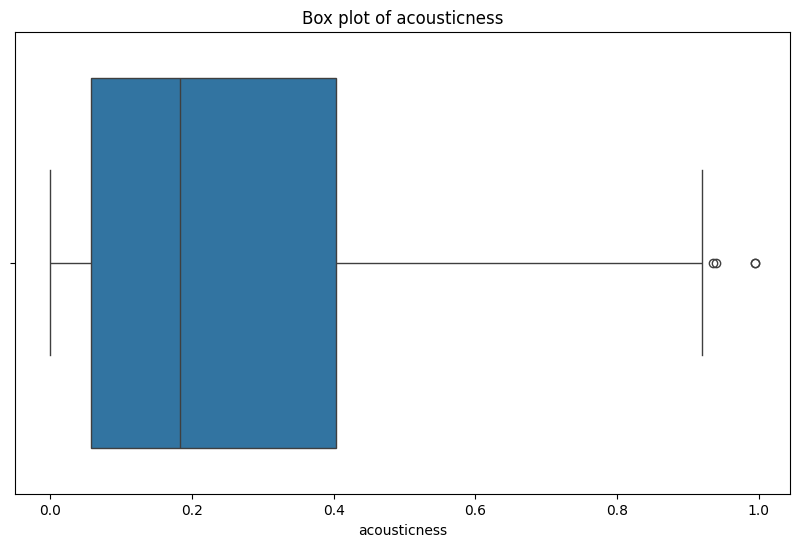


 Sum of acousticness Outliers: 4


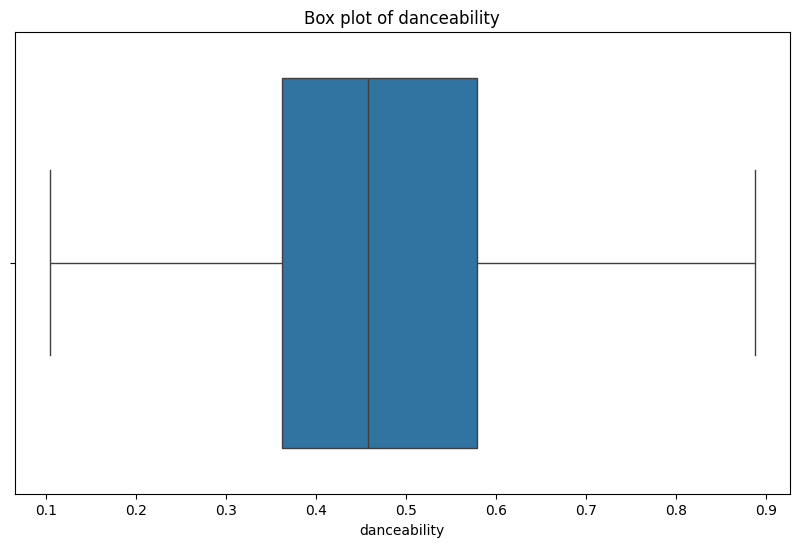


 Sum of danceability Outliers: 0



 Sum of energy Outliers: 6


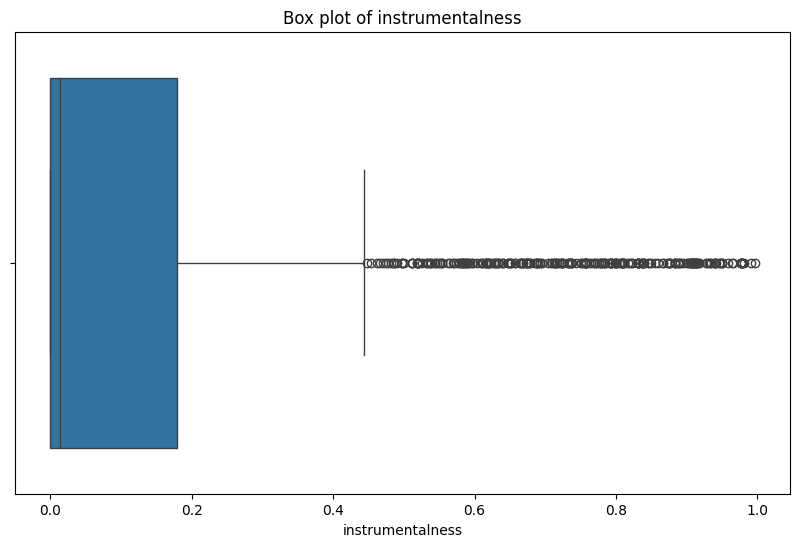


 Sum of instrumentalness Outliers: 269


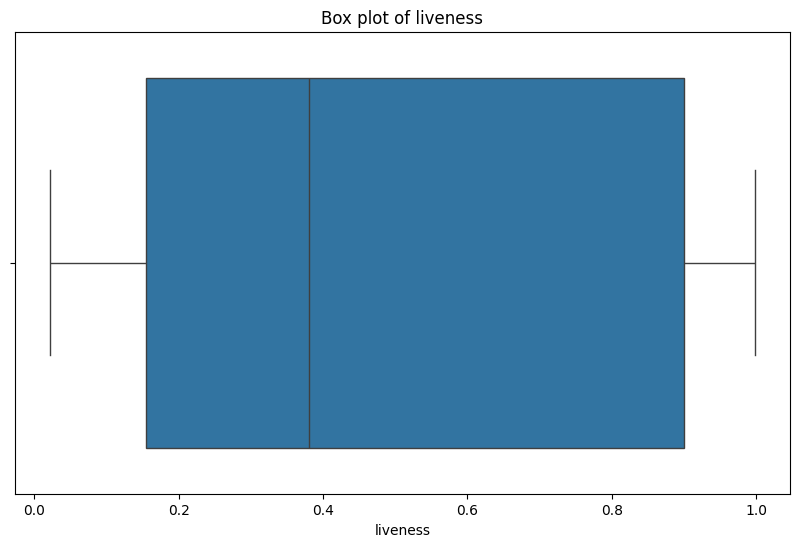


 Sum of liveness Outliers: 0


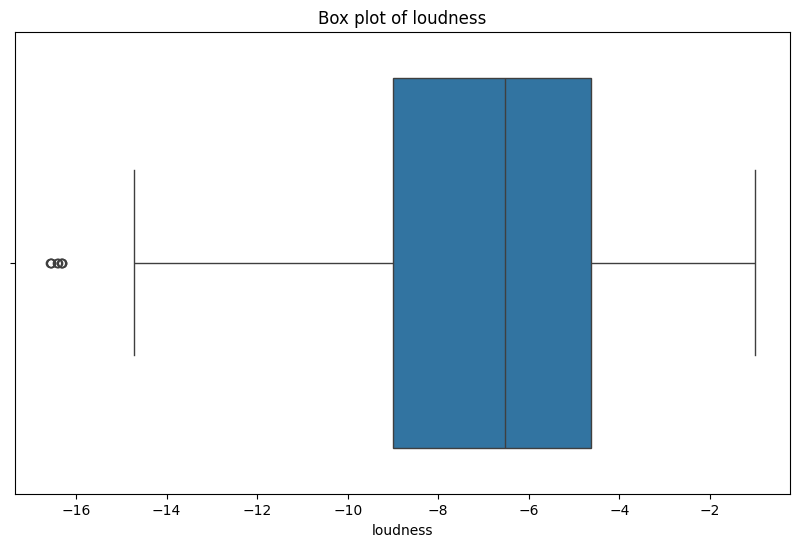


 Sum of loudness Outliers: 8


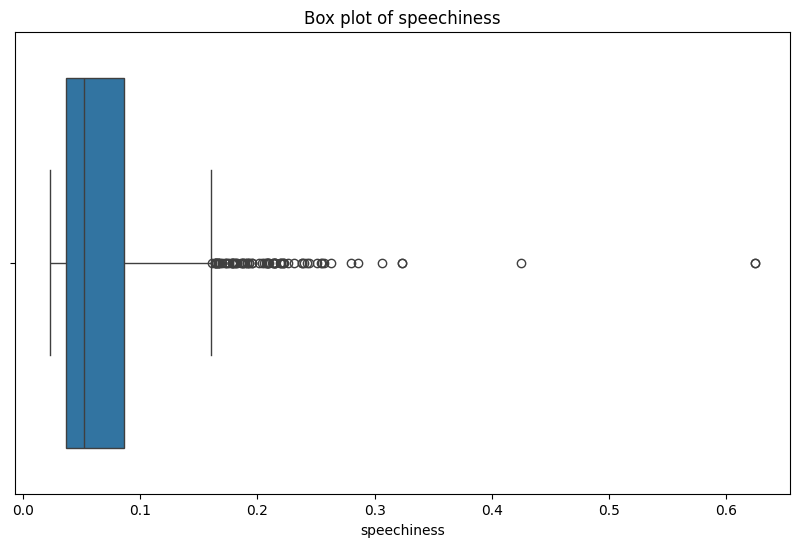


 Sum of speechiness Outliers: 76


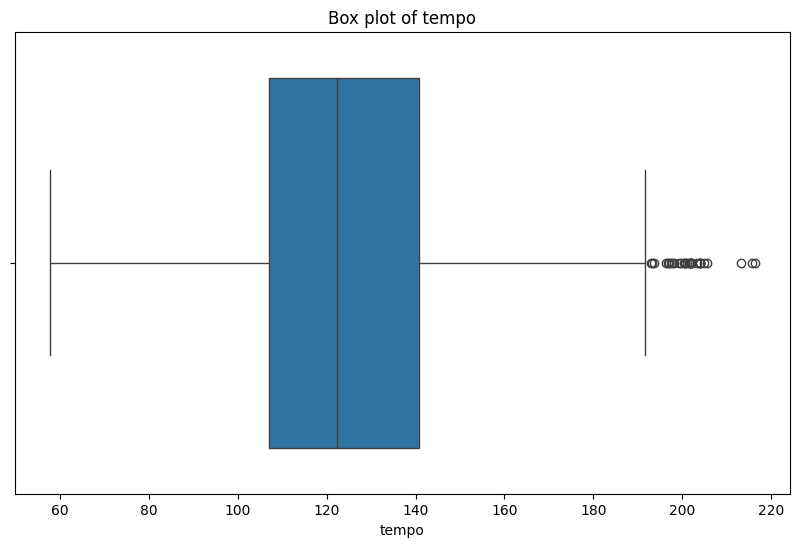


 Sum of tempo Outliers: 31


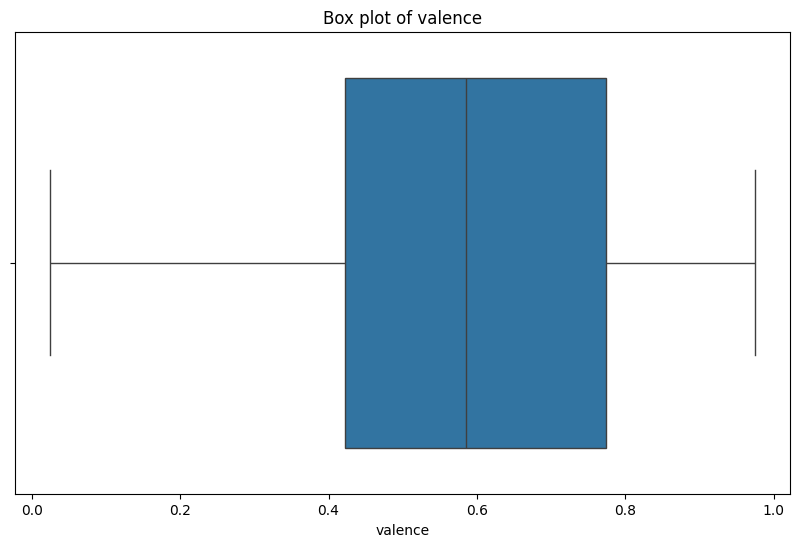


 Sum of valence Outliers: 0


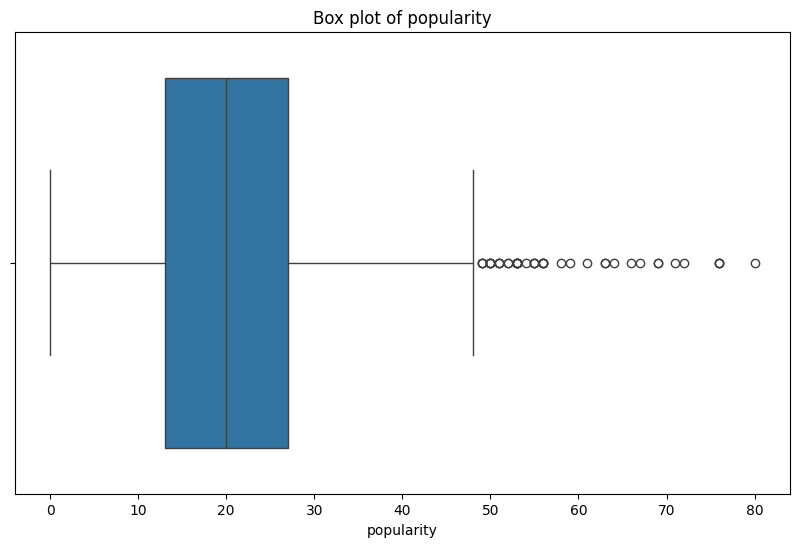


 Sum of popularity Outliers: 42



 Sum of duration_ms Outliers: 53
New dataframe after removing outliers
                             name               album release_date  \
0     Street Fighting Man - Live  Licked Live In NYC   2022-06-10   
1             Start Me Up - Live  Licked Live In NYC   2022-06-10   
2              Don’t Stop - Live  Licked Live In NYC   2022-06-10   
3              Monkey Man - Live  Licked Live In NYC   2022-06-10   
4                   Angie - Live  Licked Live In NYC   2022-06-10   
...                          ...                 ...          ...   
1116                       Carol  The Rolling Stones   1964-04-16   
1117                     Tell Me  The Rolling Stones   1964-04-16   
1118         Can I Get A Witness  The Rolling Stones   1964-04-16   
1119  You Can Make It If You Try  The Rolling Stones   1964-04-16   
1120             Walking The Dog  The Rolling Stones   1964-04-16   

      track_number  acousticness  danceability  energy  instrumentalness  \
0                2    

In [2]:
# read the csv file using pandas
spotify = pd.read_csv('rolling_stones_spotify.csv')
print('The original data is as follows: \n',spotify)

# Dropping the irrelavant columns
spotify.drop(columns=['Unnamed: 0' ,'id', 'uri'], inplace=True)

# Convert release_date to pandas datetime
spotify['release_date'] = pd.to_datetime(spotify['release_date'])

#  Inspect the data manually to identify missing or incorrect information
print('Columns with N\A values:')
print(spotify.isna().sum())
print('Columns with duplicated values:')
print(spotify.duplicated().sum())
print('Columns with null values:')
print(spotify.isnull().sum())

# Function for visualsing Outliers for each coloumn
def Boxplot(col, spotify):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, data=spotify)
    plt.title(f'Box plot of {col}')
    plt.show()

# Check for columns with numerical data types 
numerical_columns = spotify.select_dtypes(include=['float64', 'int64']).columns
#  next we drop track number as it is a irrelavant to outliers
numerical_columns= numerical_columns.drop(labels=['track_number'])
print('Treating Outliers for:',numerical_columns)

# Visualising outliers for each varibale and treating them using IQR method
for col in numerical_columns:
    Boxplot(col, spotify)
    Q_down = spotify[col].quantile(0.25)
    Q_up= spotify[col].quantile(0.75)
    IQR = Q_up-Q_down
    T = 1.5 # The threshold
    outliers = ((spotify[col] < (Q_down - (T * IQR))) | (spotify[col] > (Q_up + (T * IQR)))).sum()
    print(f'\n Sum of {col} Outliers:',outliers)
    spotify = spotify[(spotify[col] >= (Q_down - (T * IQR))) & (spotify[col] <= (Q_up + (T * IQR)))]

# Reseting the row index to start numbering from 0
spotify.reset_index(drop=True, inplace=True) 
print('New dataframe after removing outliers\n',spotify)


Performing exploratory data analysis and feature engineering as follows:
Utilizing suitable visualizations to identify the two albums that should be recommended to anyone based on the number of popular songs in each album.
Conducting exploratory data analysis to delve into various features of songs, aiming to identify patterns.
Examining the relationship between a song's popularity and various factors, exploring how this correlation has evolved.

Threshold avreage for top 10% in popularity: 39.642857142857146
                                                   name  \
106                                        Angie - 2020   
152                              Living In A Ghost Town   
153                                         Start Me Up   
155                                     Beast Of Burden   
158                                            Miss You   
160                                          Don't Stop   
297                                      Just Your Fool   
300                                    Ride 'Em On Down   
419                   Streets Of Love - Remastered 2009   
426                   Laugh, I Nearly Died - Remastered   
464                               Anybody Seen My Baby?   
481                                      Out Of Control   
482                                         Saint Of Me   
513                                  You Got Me Rocking   
518                                        Out Of T

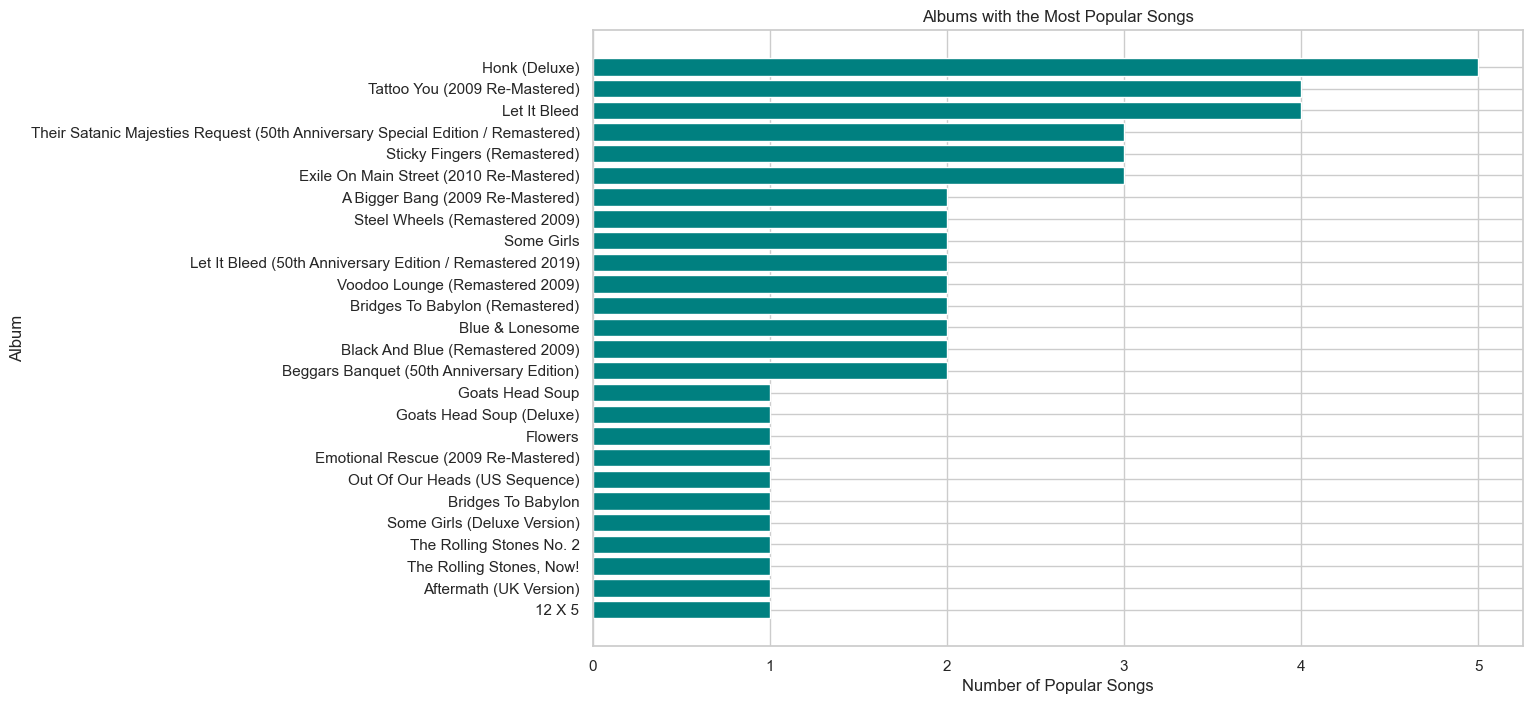

Top Two Recommended Albums:
                            album  num_popular_songs
13                  Honk (Deluxe)                  5
21  Tattoo You (2009 Re-Mastered)                  4


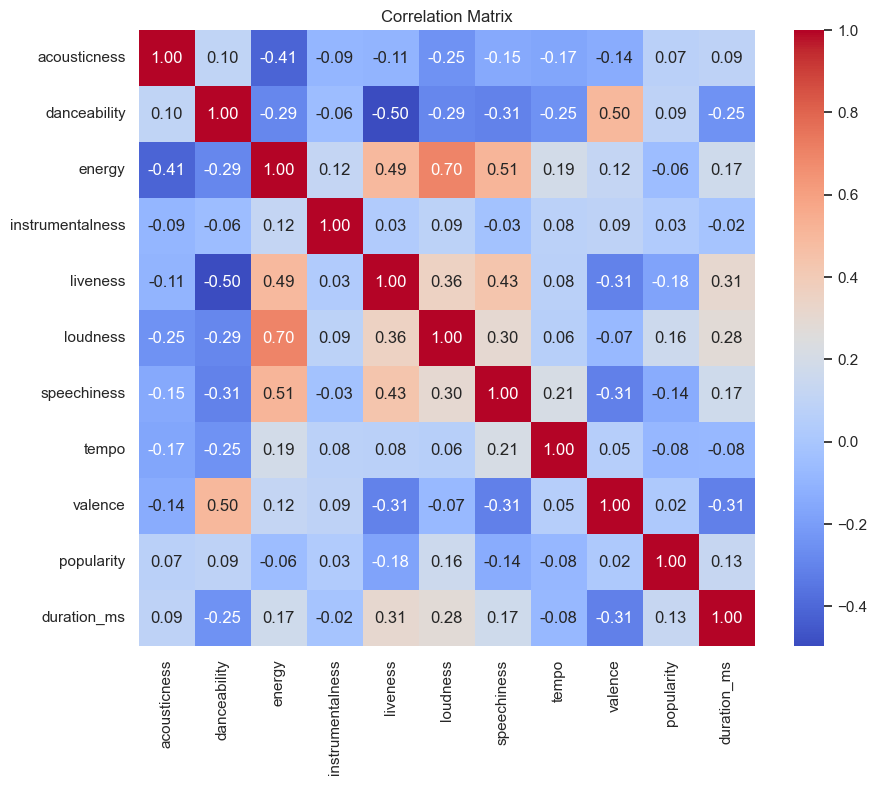

In [14]:
# Define a threshold for what constitutes a "popular" song
# Sort the dataset by popularity in descending order
sorted_pop = spotify.sort_values(by='popularity', ascending=False)

# Determine the number of songs in the top 10%
top_10_percent = int(0.10 * len(sorted_pop))

# Calculate the average popularity of the top 10% of songs
top_10_percent_songs = sorted_pop.head(top_10_percent)
threshold = top_10_percent_songs['popularity'].mean()
print('Threshold avreage for top 10% in popularity:',threshold)
popularity_threshold = threshold 

# Filter songs that are above the popularity threshold
popular_songs = spotify[spotify['popularity'] > popularity_threshold]
print(popular_songs)

# Count the number of popular songs per album
album_popularity = popular_songs.groupby('album').size().reset_index(name='num_popular_songs')
print(album_popularity)

# Sort the albums by the number of popular songs
album_popularity_sorted = album_popularity.sort_values(by='num_popular_songs', ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
plt.barh(album_popularity_sorted['album'], album_popularity_sorted['num_popular_songs'], color='teal')
plt.xlabel('Number of Popular Songs')
plt.ylabel('Album')
plt.title('Albums with the Most Popular Songs')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values on top
plt.show()

# Identify the top two albums
top_two_albums = album_popularity_sorted.head(2)
print("Top Two Recommended Albums:")
print(top_two_albums)

# Set up the visualization style
sns.set_theme(style="whitegrid")

# Plot the distribution of numerical features
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
fig.suptitle('Distribution of Numerical Features', fontsize=16)

for i, col in enumerate(numerical_columns):
    if col in spotify.columns:
        sns.histplot(spotify[col], kde=True, ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(col)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Plot correlations with popularity
plt.figure(figsize=(10, 8))
correlation_matrix = spotify[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Scatter plot for popularity vs other features
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
fig.suptitle('Popularity vs Other Features', fontsize=16)

for i, col in enumerate(numerical_columns):
    if col != 'popularity':
        sns.scatterplot(x=spotify[col], y=spotify['popularity'], ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(f'Popularity vs {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


Providing insights on the significance of dimensionality reduction techniques. We first standardize the dataset and then perform PCA on it.

Dataset after Standardzing:
 [[ 0.92112094 -1.12360626  1.04102674 ... -1.23045861  1.32199641
   0.0634147 ]
 [ 0.82413332 -0.68861934  1.06352382 ... -1.25297384  1.32199641
   0.19399128]
 [ 0.75023799 -1.29035124  1.06352382 ... -1.73479971  1.13534008
   0.74242077]
 ...
 [ 0.6163027   2.24029256 -0.03320878 ...  1.09761595  0.94868374
  -0.94454968]
 [-0.09493988  1.58781218 -1.31554228 ... -0.26680686  0.66869924
  -1.65581092]
 [ 0.67172419  1.7835563   0.86667438 ...  1.70102406  1.41532458
  -0.77319326]]


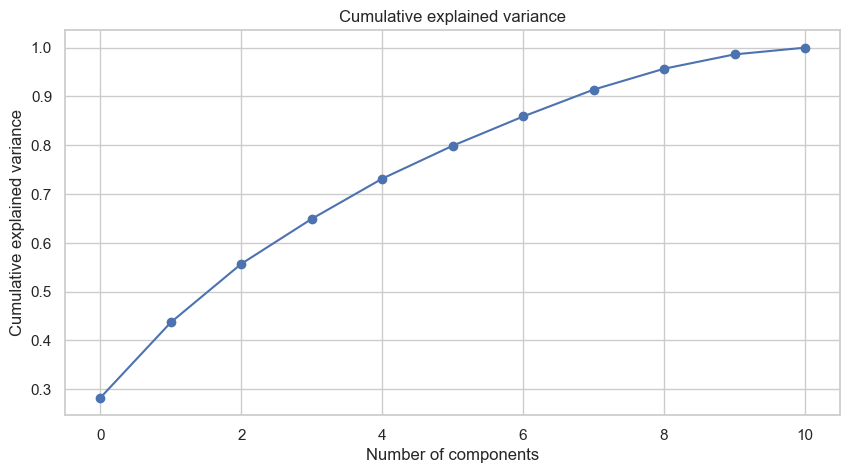


 Number of dimendsion needed to retain 95% of the variance =  9
New dataset after performing PCA:
 [[-2.18831927  0.59602285 -0.93506587 ...  1.10800223 -0.87867209
  -0.48712734]
 [-2.64772244  0.11630303 -1.01180642 ...  2.27451537  0.18441281
  -0.52627171]
 [-2.64131711  1.56858501 -0.6532597  ...  0.74272029 -0.46675003
  -0.4293284 ]
 ...
 [ 2.18277859 -0.92308318 -1.032645   ...  1.44468841  0.27275566
  -0.12826038]
 [ 2.41700291 -0.00632702  0.19630757 ...  1.64052704  0.18129342
  -0.29720088]
 [ 2.00614857 -1.78814862 -1.32370199 ...  0.41688943 -0.23308338
  -0.45474199]]


In [17]:
# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spotify[numerical_columns])
print('Dataset after Standardzing:\n',scaled_data)

# Applying PCA
# applying dimension reduction 
pca = PCA()
test_pca = pca.fit(scaled_data)

# finding the number of components needed to retain atleat 95% of the variance
figure = plt.figure(figsize=(10,5))
cumsum = np.cumsum(test_pca.explained_variance_ratio_)
plt.plot(cumsum, marker='o')
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

# No.  of Principle componets needed is as follows
d = np.argmax(cumsum >= 0.95) + 1
print('\n Number of dimendsion needed to retain 95% of the variance = ',d)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=9)
pca_data = pca.fit_transform(scaled_data)

print('New dataset after performing PCA:\n',pca_data)


Performing cluster analysis
a. Identifing the right number of clusters using combination of elbow method and silhouette score.
b. Using K-means clustering algorithm.
c. Define each cluster based on the features.

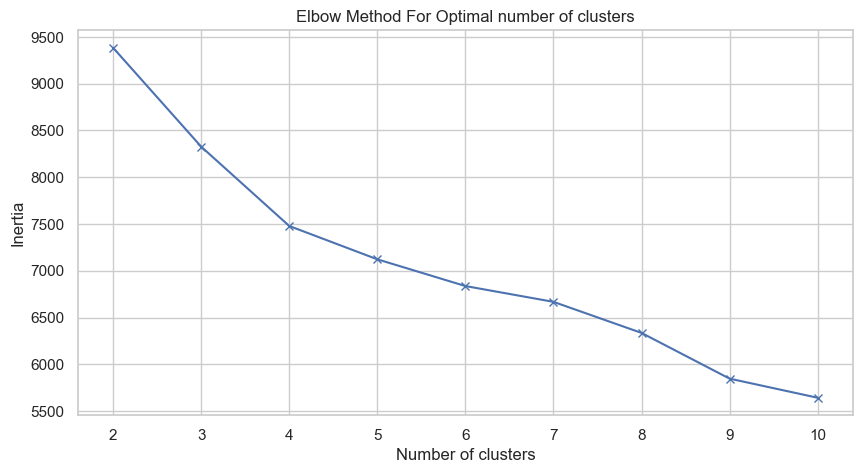

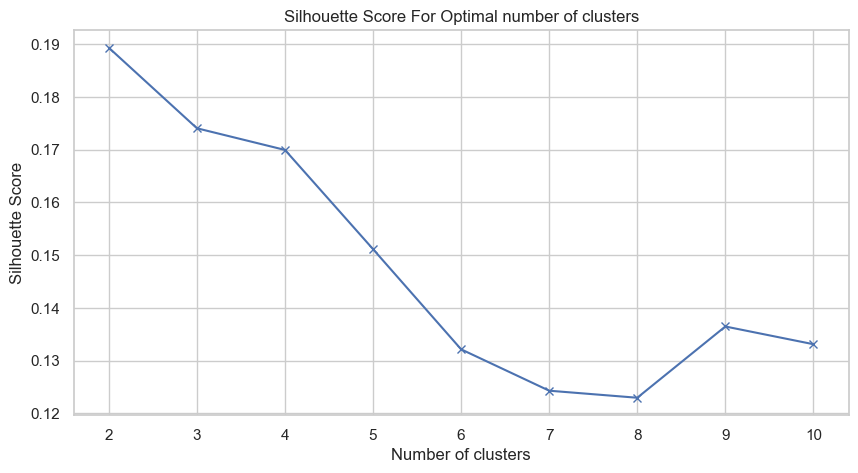

Assuming the optimal cluster as 4 since the elbow point is at 4 for elbow method and which also has the highest Silhouette Score relative to the rest above 4.

Clusters based on each feature from original dataset:
    acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0      0.153337      0.536244  0.865776          0.080834  0.336699 -5.108216   
1      0.234464      0.589450  0.652615          0.032949  0.242416 -9.906346   
2      0.168169      0.370613  0.928880          0.046527  0.836960 -5.361302   
3      0.474539      0.445872  0.582075          0.021431  0.361224 -8.297421   

   speechiness       tempo   valence  popularity    duration_ms  cluster  
0     0.049349  121.749184  0.751396   25.449384  250797.250281        0  
1     0.047374  124.475848  0.724305   15.252104  182865.993065        1  
2     0.089138  131.458379  0.477556   16.586409  281377.904338        2  
3     0.041832  108.383123  0.385114   23.866693  277430.500915        3  


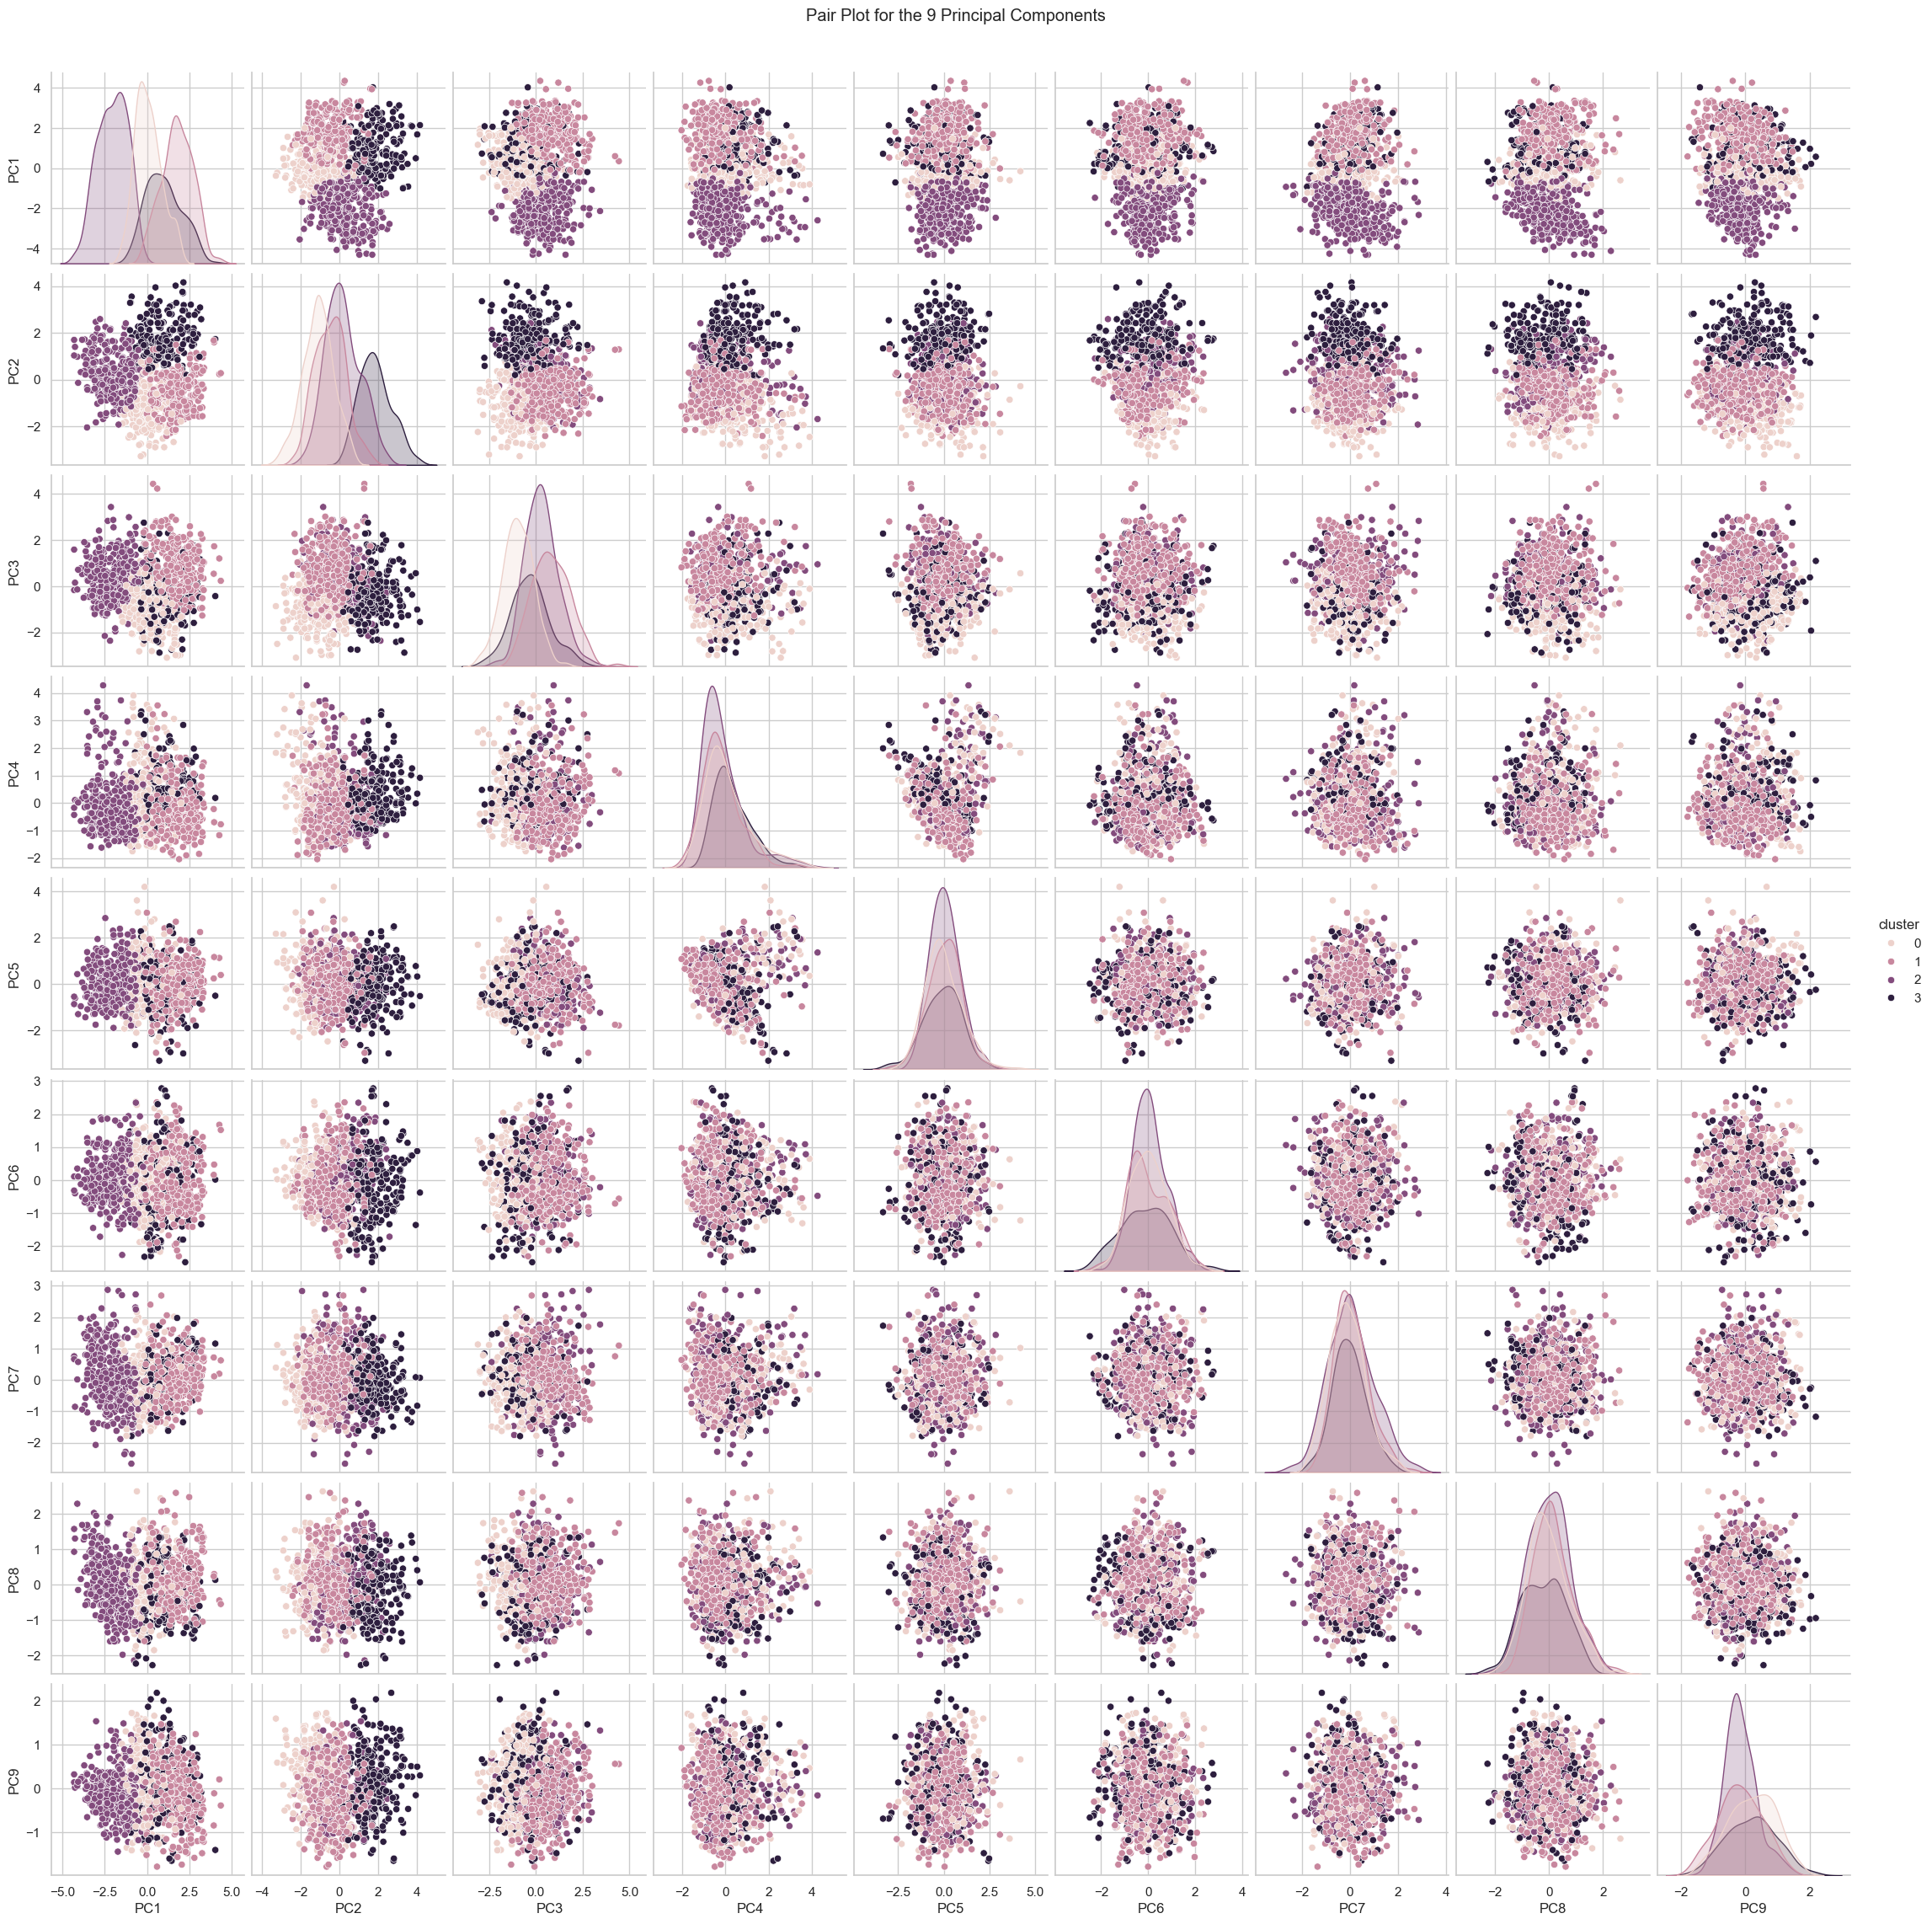

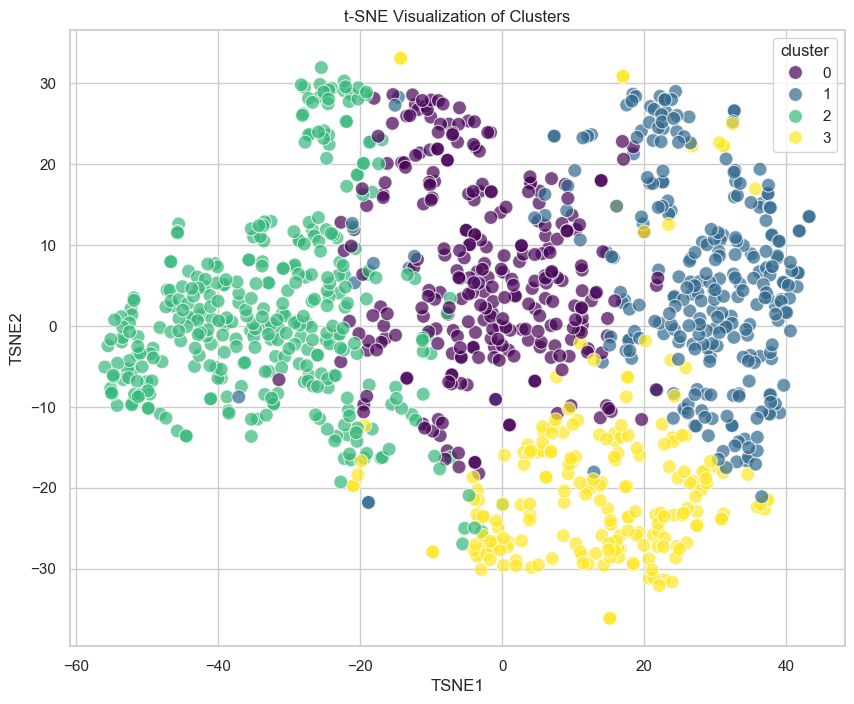

In [20]:
# Determine the optimal number of clusters using the Elbow method and Silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)

# for loop to find the inertia and silhouette score for clusters from range 2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Plot the Elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal number of clusters')
plt.show()

# Plot the Silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal number of clusters')
plt.show()


# Choose the optimal number of clusters based on the plots 
optimal_k = 4
print('Assuming the optimal cluster as 4 since the elbow point is at 4 for elbow method and which also has the highest Silhouette Score relative to the rest above 4.\n')
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(9)])
pca_df['cluster'] = kmeans.fit_predict(pca_data)


# Analyze and interpret clusters
cluster_centers = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numerical_columns)
cluster_centers_df['cluster'] = range(optimal_k)

print('Clusters based on each feature from original dataset:\n',cluster_centers_df)

# Pair plot for the principal components
sns.pairplot(pca_df, hue='cluster', vars=[f'PC{i+1}' for i in range(9)])
plt.suptitle('Pair Plot for the 9 Principal Components', y=1.02)
plt.show()

# t-SNE visualization to visualise the 9 PC to 2 PC for the purpose of visualising the clusters in 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(pca_data)

# Create a DataFrame with t-SNE data and cluster labels
tsne_df = pd.DataFrame(tsne_data, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = pca_df['cluster']

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='viridis', data=tsne_df, s=100, alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.show()